In [57]:
import pandas as pd 
import numpy as np 
from pathlib import Path
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#from catboost import CatBoost
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt 
import random 
import statsmodels.api as sm
plt.style.use('fivethirtyeight')
from statsmodels.tsa.seasonal import seasonal_decompose
class CFG:
    img_dim1 = 20
    img_dim2 = 10
    
random.seed(7)
from time import sleep 
from tqdm import  tqdm, trange
#setting the metri>cs: 

ModuleNotFoundError: No module named 'tqdm'

In [ ]:
#

- try to fill missing values
- apply auto-correlation 

In [9]:
data_path = Path('/Users/ahmed/Downloads/computerscience/Kaggle/Rohlik Orders Forecasting Challenge/Data')
train = pd.read_csv(data_path / 'train.csv')
test = pd.read_csv(data_path / 'test.csv')
test_id = test['id']
for df in (train,test): 
    df['date'] = pd.to_datetime(df['date'])
    df.set_index(df['date'],inplace=True)

train.head()

,warehouse,date,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id
date,,,,,,,,,,,,,,,,,,
2020-12-05,Prague_1,2020-12-05,6895.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1722.0,32575.0,Prague_1_2020-12-05
2020-12-06,Prague_1,2020-12-06,6584.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1688.0,32507.0,Prague_1_2020-12-06
2020-12-07,Prague_1,2020-12-07,7030.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1696.0,32552.0,Prague_1_2020-12-07
2020-12-08,Prague_1,2020-12-08,6550.0,NaN,0,0,0,0,0,0,0,0.0,0,0.8,0.0,1681.0,32423.0,Prague_1_2020-12-08
2020-12-09,Prague_1,2020-12-09,6910.0,NaN,0,0,0,0,0,0,0,0.0,0,0.5,0.0,1704.0,32410.0,Prague_1_2020-12-09


# Exploratory Data Analysis  (EDA) 

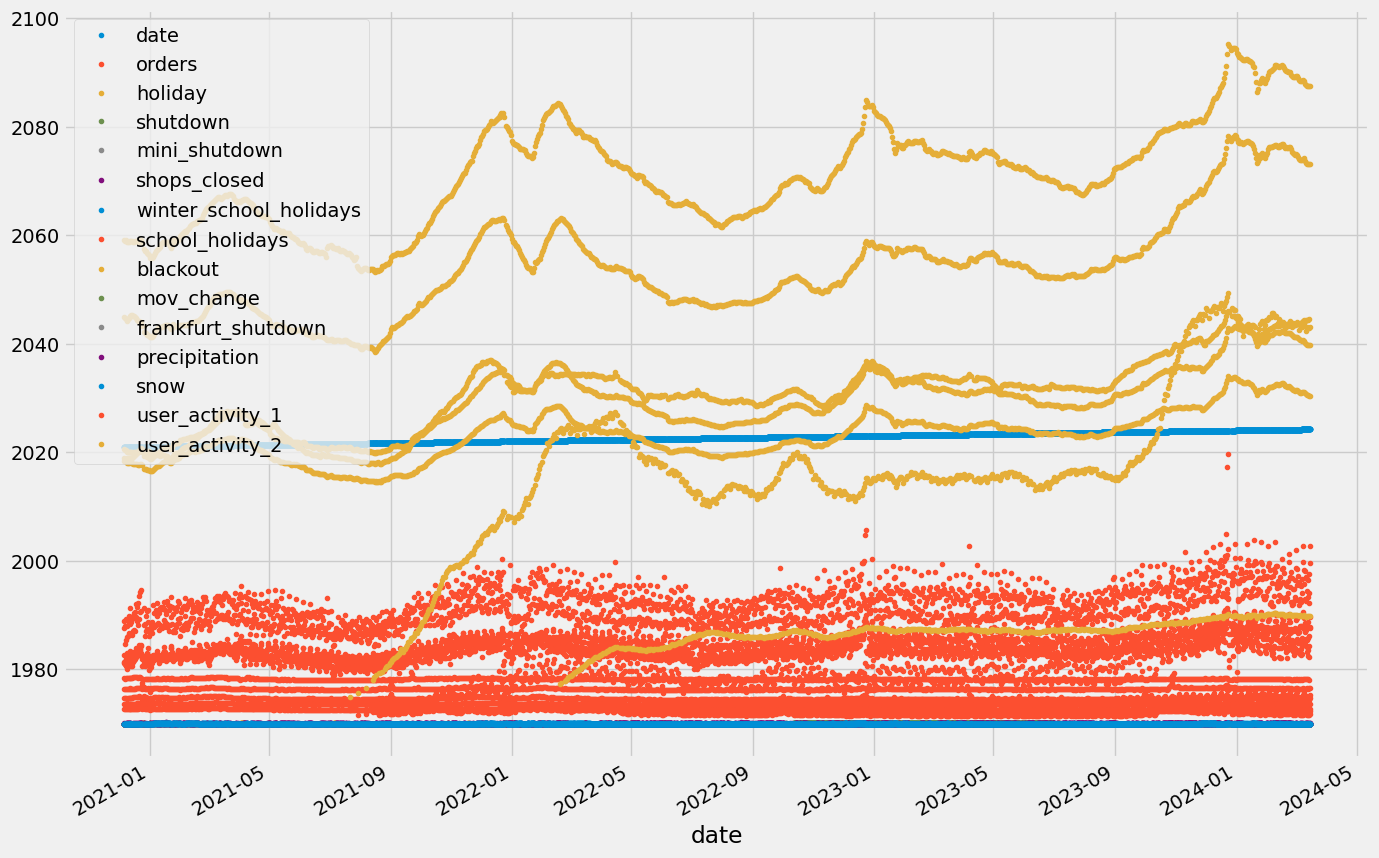

In [10]:
train.plot(style='.',figsize=(15,11))
plt.show()

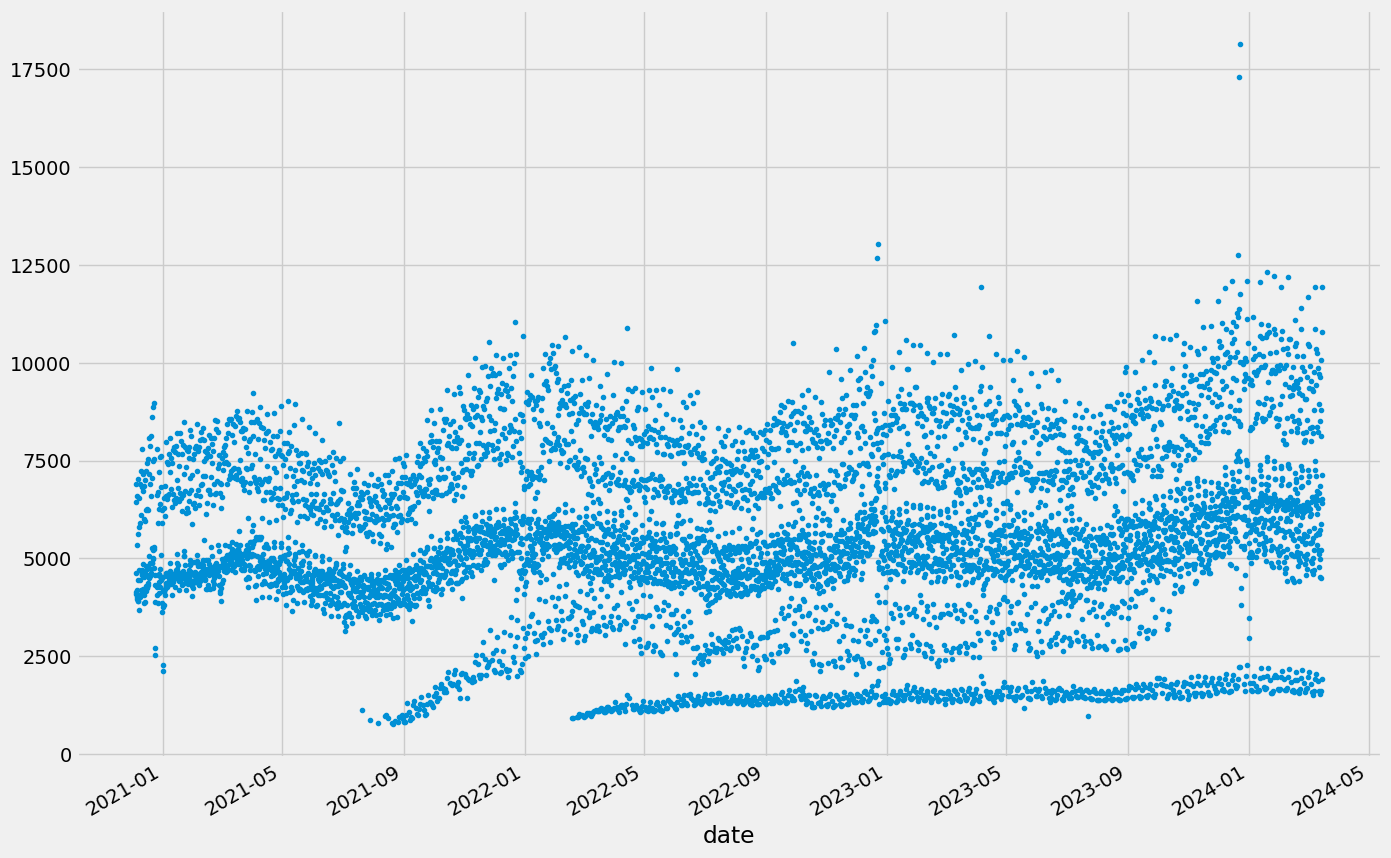

In [11]:
train.orders.plot(style='.',figsize=(15,11))
plt.show()

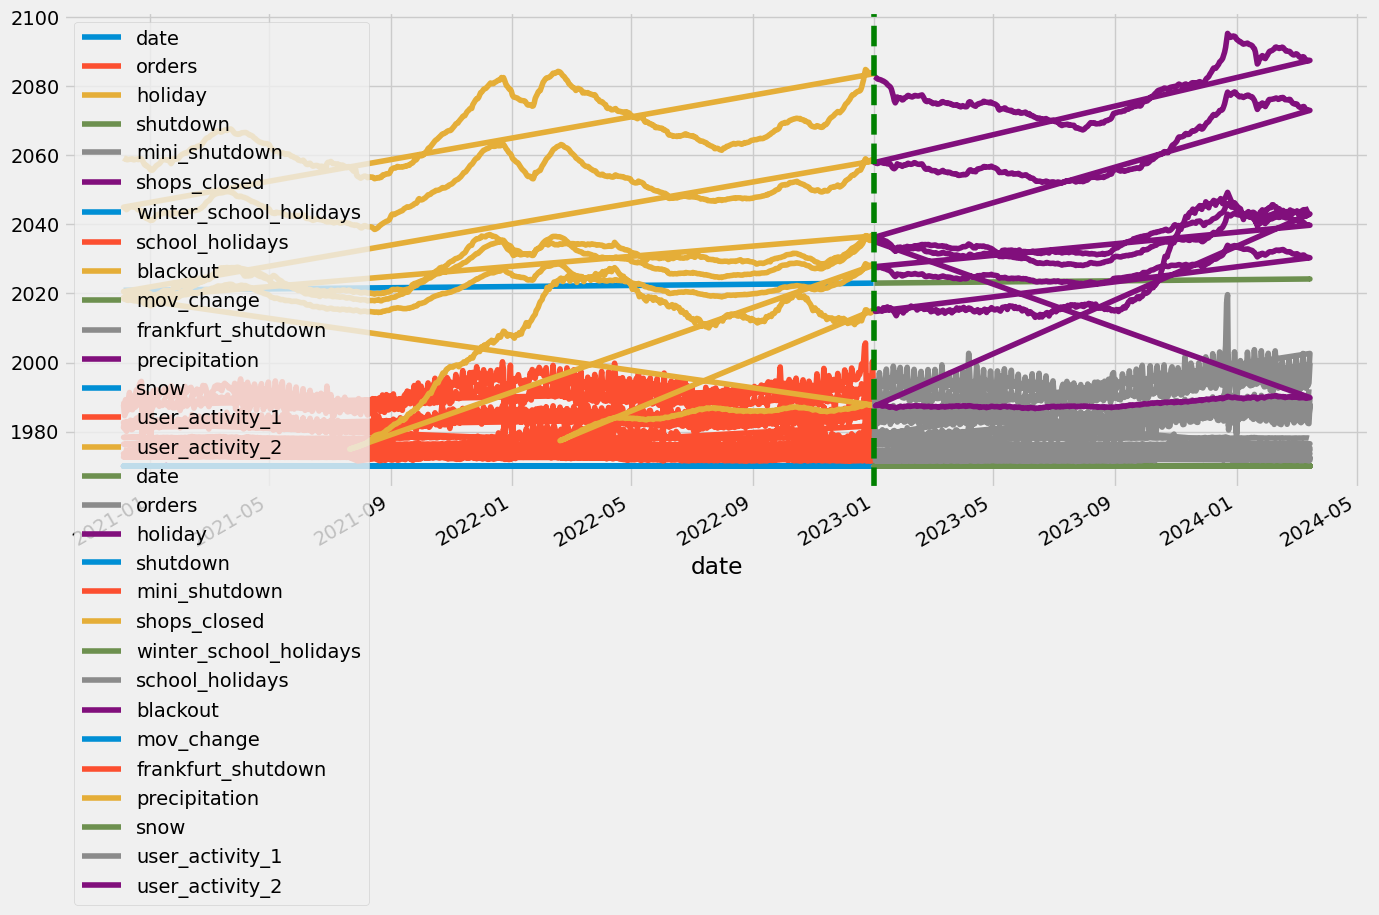

In [12]:
trainset = train.loc[train.date < '01-01-2023']
testset  =  train.loc[train.date >= '01-01-2023']
fig , ax = plt.subplots(figsize=(15,7))
trainset.plot(ax=ax, label='training_set')
testset.plot(ax=ax, label='Test_set')
ax.axvline('01-01-2023', color='green',ls='--')
plt.show()

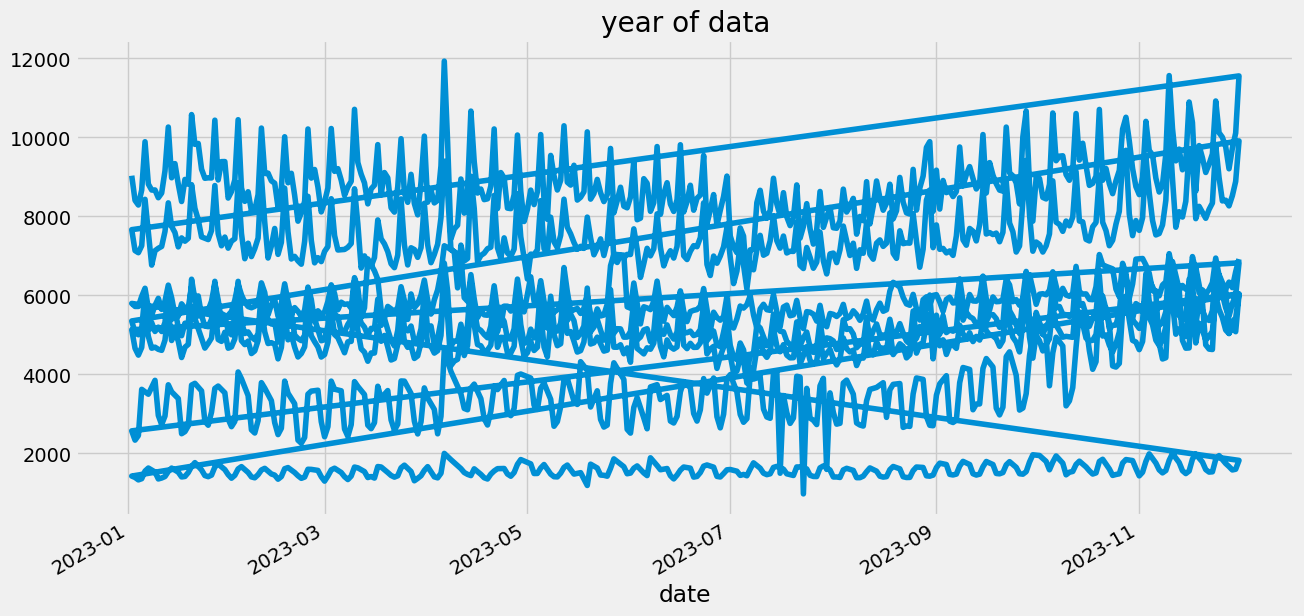

In [13]:
train['orders'].loc[((train.index > '01-01-2023') & (train.index <='12-01-2023'))].plot(figsize=(14,7), title='year of data')
plt.show()

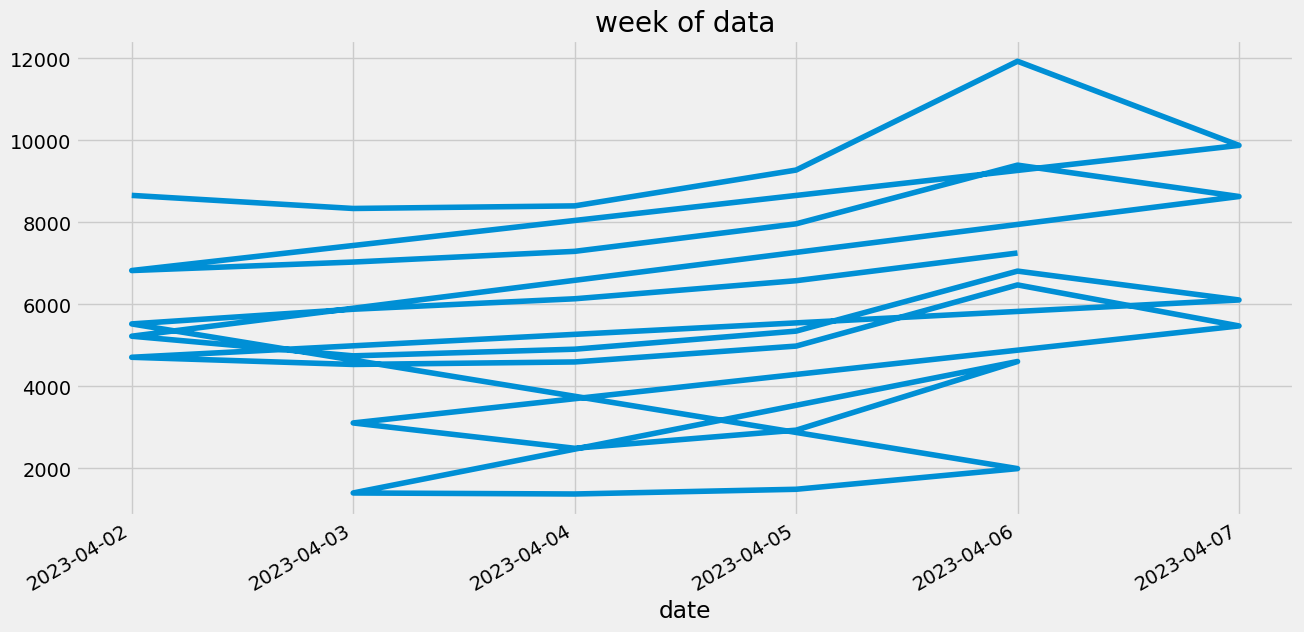

In [14]:
train.orders.loc[(train.date > '04-01-2023') & (train.date <='04-07-2023')].plot(figsize=(14,7), title='week of data')
plt.show()

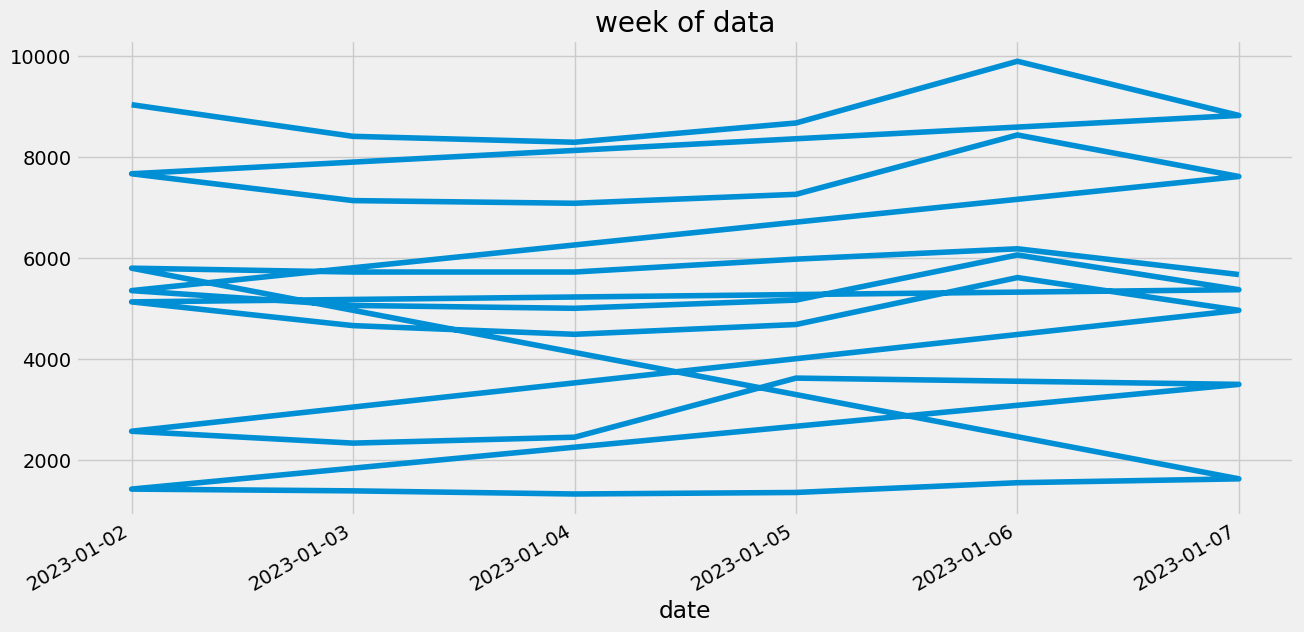

In [15]:
train.orders.loc[(train.date > '01-01-2023') & (train.date <='01-07-2023')].plot(figsize=(14,7), title='week of data')
plt.show()

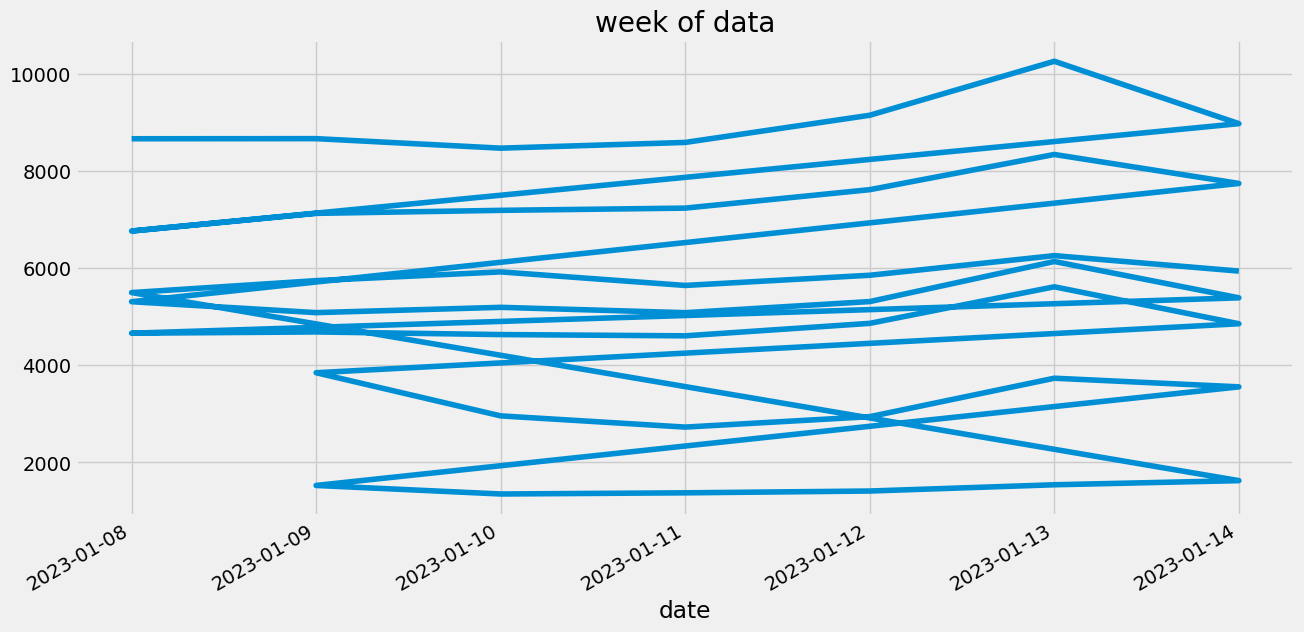

In [16]:
train.orders.loc[(train.date > '01-07-2023') & (train.date <='01-14-2023')].plot(figsize=(14,7), title='week of data')
plt.show()

In [17]:
train.shape, test.shape

((7340, 18), (397, 8))

In [18]:
train.isnull().mean(axis=0)*100

warehouse                  0.000000
date                       0.000000
orders                     0.000000
holiday_name              97.029973
holiday                    0.000000
shutdown                   0.000000
mini_shutdown              0.000000
shops_closed               0.000000
winter_school_holidays     0.000000
school_holidays            0.000000
blackout                   0.000000
mov_change                 0.000000
frankfurt_shutdown         0.000000
precipitation              3.678474
snow                       3.678474
user_activity_1            0.000000
user_activity_2            0.000000
id                         0.000000
dtype: float64

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7340 entries, 2020-12-05 to 2024-03-14
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   warehouse               7340 non-null   object        
 1   date                    7340 non-null   datetime64[ns]
 2   orders                  7340 non-null   float64       
 3   holiday_name            218 non-null    object        
 4   holiday                 7340 non-null   int64         
 5   shutdown                7340 non-null   int64         
 6   mini_shutdown           7340 non-null   int64         
 7   shops_closed            7340 non-null   int64         
 8   winter_school_holidays  7340 non-null   int64         
 9   school_holidays         7340 non-null   int64         
 10  blackout                7340 non-null   int64         
 11  mov_change              7340 non-null   float64       
 12  frankfurt_shutdown      7340 n

In [20]:
def null_evaluation(column): 
    print('__________________________')
    print (column)
    print('__________________________')
    total = len(train[column])
    missing_values = train[column].isnull().sum()
    missing_percentage = train[column].isnull().mean(axis=0) * 100
    non_null = abs(missing_values - total)
    print('total_values             :', total)
    print('missing_values           :', missing_values)
    print('non null                 :', non_null)
    print('missing value percentage :',missing_percentage)

In [21]:
null_evaluation('holiday_name')
null_evaluation('precipitation')
null_evaluation('snow')

__________________________
holiday_name
__________________________
total_values             : 7340
missing_values           : 7122
non null                 : 218
missing value percentage : 97.02997275204359
__________________________
precipitation
__________________________
total_values             : 7340
missing_values           : 270
non null                 : 7070
missing value percentage : 3.6784741144414173
__________________________
snow
__________________________
total_values             : 7340
missing_values           : 270
non null                 : 7070
missing value percentage : 3.6784741144414173


In [22]:
train.isnull().sum()

warehouse                    0
date                         0
orders                       0
holiday_name              7122
holiday                      0
shutdown                     0
mini_shutdown                0
shops_closed                 0
winter_school_holidays       0
school_holidays              0
blackout                     0
mov_change                   0
frankfurt_shutdown           0
precipitation              270
snow                       270
user_activity_1              0
user_activity_2              0
id                           0
dtype: int64

In [23]:
train.head()

,warehouse,date,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id
date,,,,,,,,,,,,,,,,,,
2020-12-05,Prague_1,2020-12-05,6895.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1722.0,32575.0,Prague_1_2020-12-05
2020-12-06,Prague_1,2020-12-06,6584.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1688.0,32507.0,Prague_1_2020-12-06
2020-12-07,Prague_1,2020-12-07,7030.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1696.0,32552.0,Prague_1_2020-12-07
2020-12-08,Prague_1,2020-12-08,6550.0,NaN,0,0,0,0,0,0,0,0.0,0,0.8,0.0,1681.0,32423.0,Prague_1_2020-12-08
2020-12-09,Prague_1,2020-12-09,6910.0,NaN,0,0,0,0,0,0,0,0.0,0,0.5,0.0,1704.0,32410.0,Prague_1_2020-12-09


In [24]:
train.describe()

,date,orders,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2
count,7340,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7070.000000,7070.000000,7340.000000,7340.000000
mean,2022-08-27 18:17:27.629427968,5535.443869,0.027248,0.000136,0.000545,0.010899,0.029973,0.007084,0.000954,0.221499,0.000272,1.621126,0.290112,1633.545777,23477.031335
min,2020-12-05 00:00:00,790.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,482.000000,1797.000000
25%,2021-11-23 00:00:00,4434.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,945.000000,18509.000000
50%,2022-09-08 00:00:00,5370.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1349.000000,22267.000000
75%,2023-06-13 06:00:00,7009.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2308.000000,30028.750000
max,2024-03-15 00:00:00,18139.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,80.000000,19.840000,3437.000000,45769.000000
std,NaN,2182.680279,0.162816,0.011672,0.023340,0.103836,0.170524,0.083876,0.030869,0.410293,0.016506,4.542875,1.546102,784.167637,8934.848328


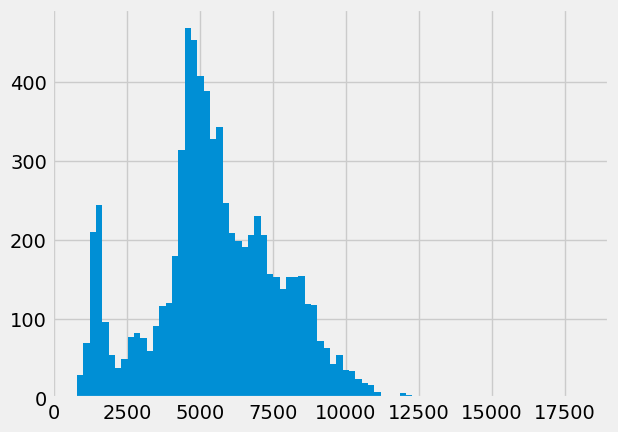

In [25]:
plt.hist(train['orders'], bins=80)
plt.show()

In [26]:
train

,warehouse,date,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id
date,,,,,,,,,,,,,,,,,,
2020-12-05,Prague_1,2020-12-05,6895.0,NaN,0,0,0,0,0,0,0,0.0,0,0.00,0.0,1722.0,32575.0,Prague_1_2020-12-05
2020-12-06,Prague_1,2020-12-06,6584.0,NaN,0,0,0,0,0,0,0,0.0,0,0.00,0.0,1688.0,32507.0,Prague_1_2020-12-06
2020-12-07,Prague_1,2020-12-07,7030.0,NaN,0,0,0,0,0,0,0,0.0,0,0.00,0.0,1696.0,32552.0,Prague_1_2020-12-07
2020-12-08,Prague_1,2020-12-08,6550.0,NaN,0,0,0,0,0,0,0,0.0,0,0.80,0.0,1681.0,32423.0,Prague_1_2020-12-08
2020-12-09,Prague_1,2020-12-09,6910.0,NaN,0,0,0,0,0,0,0,0.0,0,0.50,0.0,1704.0,32410.0,Prague_1_2020-12-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-10,Budapest_1,2024-03-10,6733.0,NaN,0,0,0,0,0,0,0,0.0,0,1.51,0.0,2983.0,27111.0,Budapest_1_2024-03-10
2024-03-11,Budapest_1,2024-03-11,6492.0,NaN,0,0,0,0,0,0,0,0.0,0,1.03,0.0,2975.0,27133.0,Budapest_1_2024-03-11
2024-03-12,Budapest_1,2024-03-12,6661.0,NaN,0,0,0,0,0,0,0,0.0,0,0.21,0.0,2974.0,27151.0,Budapest_1_2024-03-12


In [27]:
pd.DataFrame({'train':train['warehouse'].value_counts(),'test':
              test['warehouse'].value_counts()})

,train,test
warehouse,,
Prague_1,1193,61
Brno_1,1193,61
Prague_2,1193,61
Prague_3,1193,61
Budapest_1,1154,57
Munich_1,785,48
Frankfurt_1,629,48


In [28]:
test

,warehouse,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id
date,,,,,,,,
2024-03-16,Prague_1,2024-03-16,NaN,0,0,0,0,Prague_1_2024-03-16
2024-03-17,Prague_1,2024-03-17,NaN,0,0,0,0,Prague_1_2024-03-17
2024-03-18,Prague_1,2024-03-18,NaN,0,0,0,0,Prague_1_2024-03-18
2024-03-19,Prague_1,2024-03-19,NaN,0,0,0,0,Prague_1_2024-03-19
2024-03-20,Prague_1,2024-03-20,NaN,0,0,0,0,Prague_1_2024-03-20
...,...,...,...,...,...,...,...,...
2024-05-11,Budapest_1,2024-05-11,NaN,0,0,0,0,Budapest_1_2024-05-11
2024-05-12,Budapest_1,2024-05-12,NaN,0,0,0,0,Budapest_1_2024-05-12
2024-05-13,Budapest_1,2024-05-13,NaN,0,0,0,0,Budapest_1_2024-05-13


In [29]:
train['holiday_name'].value_counts(), test['holiday_name'].value_counts()

(holiday_name
 International womens day                                       26
 Christmas Eve                                                  23
 2nd Christmas Day                                              16
 New Years Day                                                  16
 Good Friday                                                    12
 Easter Monday                                                  12
 Labour Day                                                     12
 Den osvobozeni                                                 12
 Cyrila a Metodej                                               12
 Jan Hus                                                        12
 Den ceske statnosti                                            12
 Den vzniku samostatneho ceskoslovenskeho statu                 12
 Den boje za svobodu a demokracii                               12
 Memorial Day of the Republic                                    4
 Memorial Day for the Victims of the Communist D

# Feature Engineering - Time Series

In [30]:
for df in(train,test): 
    df.index.rename('hassan', inplace=True)

In [31]:
test = pd.read_csv(data_path / 'test.csv')
train = train.sort_values('date').reset_index(drop=True) 
test = test.sort_values('date').reset_index(drop=True) 
from math import pi
for df in(train,test):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['Month'] = df['date'].dt.month 
    df['day'] = df['date'].dt.day
    #df['Year_Week'] = df['date'].dt.week
    df['dayofweek'] = df['date'].dt.dayofweek
    df['hour'] = df['date'].dt.hour
    
    #df['year_sin'] = df['year'] * np.sin(2 * pi * df['year'])
    #df['year_cos'] = df['year'] * np.cos(2 * pi * df['year'])
    #df['month_sin'] = df['month'] * np.sin(2 * pi * df['month'])
    #df['month_cos'] = df['month'] * np.cos(2 * pi * df['month'])
    #df['day_sin'] = df['day'] * np.sin(2 * pi * df['day'])
    #df['day_cos'] = df['day'] * np.cos(2 * pi * df['day'])
    df.drop('date', axis=1,inplace=True)
    
#lagging 
for df in(train,test): 
    df['day_lag1'] = df['day'].shift(1)
    df['day_lag2'] = df['day'].shift(2)

        


In [32]:
test

,warehouse,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id,year,Month,day,dayofweek,hour,day_lag1,day_lag2
0,Prague_1,NaN,0,0,0,0,Prague_1_2024-03-16,2024,3,16,5,0,NaN,NaN
1,Prague_3,NaN,0,0,0,0,Prague_3_2024-03-16,2024,3,16,5,0,16.0,NaN
2,Brno_1,NaN,0,0,0,0,Brno_1_2024-03-16,2024,3,16,5,0,16.0,16.0
3,Munich_1,NaN,0,0,0,0,Munich_1_2024-03-16,2024,3,16,5,0,16.0,16.0
4,Frankfurt_1,NaN,0,0,0,0,Frankfurt_1_2024-03-16,2024,3,16,5,0,16.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,Prague_1,NaN,0,0,0,0,Prague_1_2024-05-15,2024,5,15,2,0,15.0,15.0
393,Munich_1,NaN,0,0,0,0,Munich_1_2024-05-15,2024,5,15,2,0,15.0,15.0
394,Frankfurt_1,NaN,0,0,0,0,Frankfurt_1_2024-05-15,2024,5,15,2,0,15.0,15.0
395,Prague_3,NaN,0,0,0,0,Prague_3_2024-05-15,2024,5,15,2,0,15.0,15.0


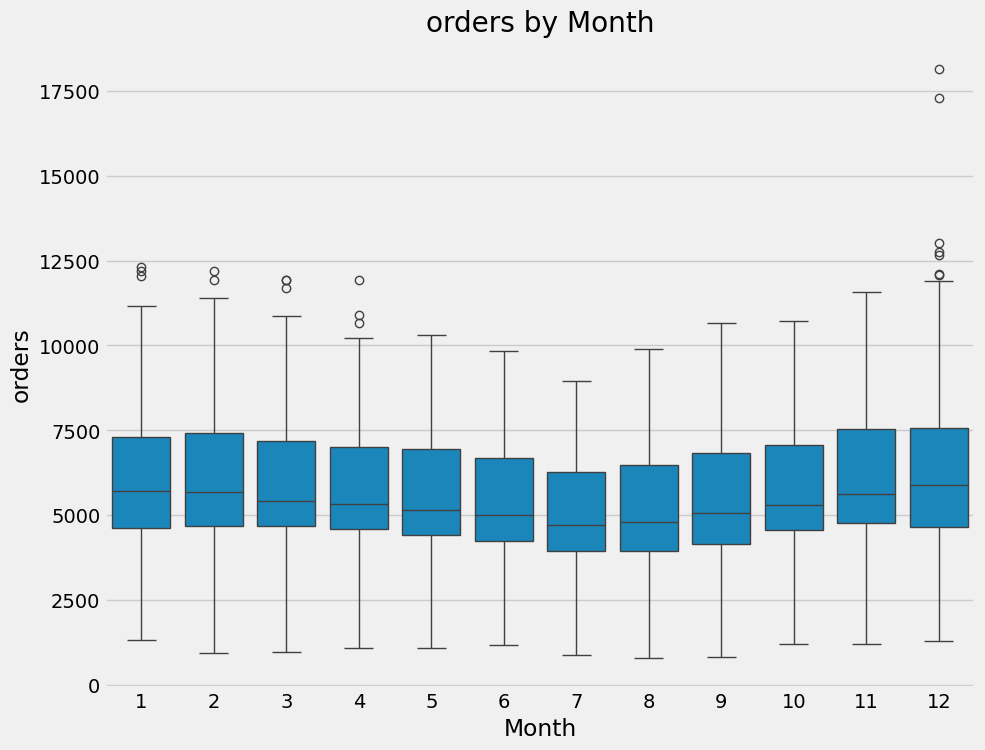

In [33]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=train, x='Month', y='orders')
ax.set_title('orders by Month')
plt.show()

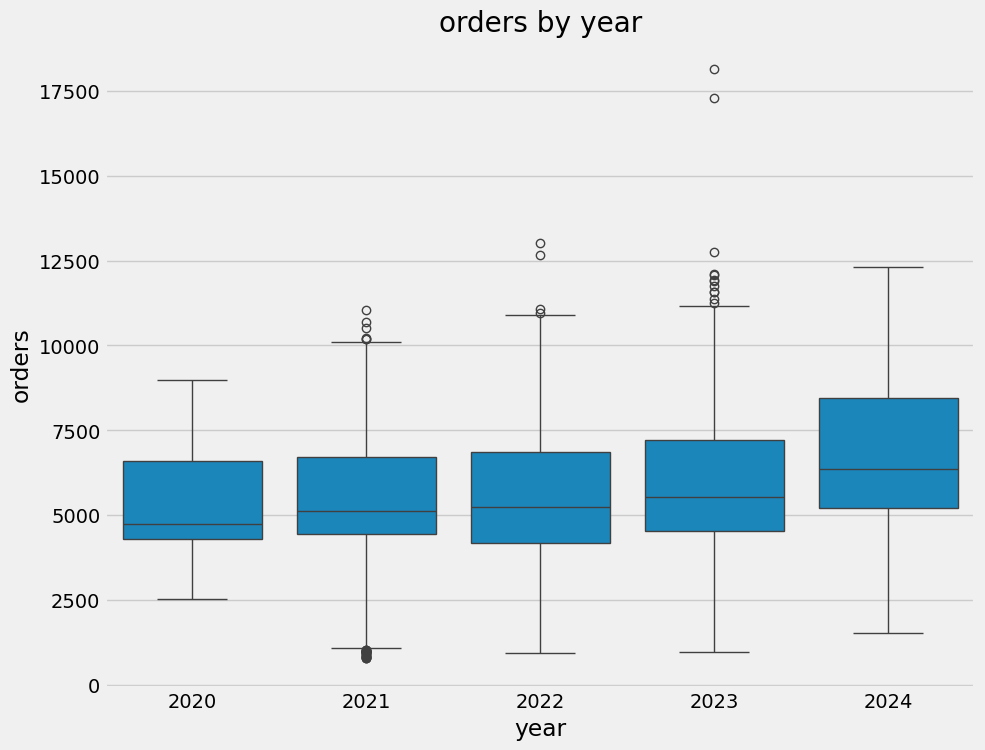

In [34]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=train, x='year', y='orders')
ax.set_title('orders by year')
plt.show()

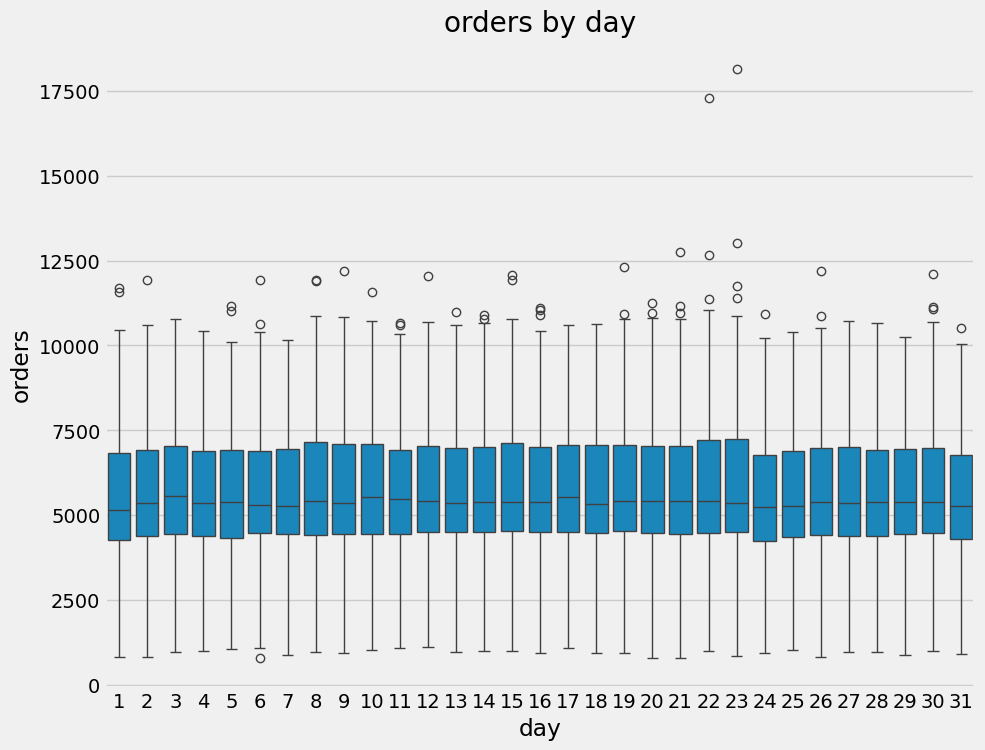

In [35]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=train, x='day', y='orders')
ax.set_title('orders by day')
plt.show()

In [36]:
for df in (train, test):
    if 'orders' not in df.columns or 'id' not in df.columns:
        # Ensure the required columns are present
        continue


    df['price_max'] = df.groupby(['id'])['orders'].transform('max')
    df['price_min'] = df.groupby(['id'])['orders'].transform('min')
    df['price_std'] = df.groupby(['id'])['orders'].transform('std')
    df['price_mean'] = df.groupby(['id'])['orders'].transform('mean')

    df['price_norm'] = df['orders'] / df['price_max']
    df['price_nunique'] = df.groupby(['id'])['orders'].transform('nunique')

    calendar_prices = df[['Month', 'year']].drop_duplicates()

    df = df.merge(calendar_prices, on=['Month', 'year'], how='left')

    # Now we can add price "momentum" (some sort of)
    # Shifted by week 
    # by month mean
    # by year mean
    df['price_momentum'] = df['orders'] / df.groupby(['id'])['orders'].transform(lambda x: x.shift(1))
    df['price_momentum_m'] = df['orders'] / df.groupby(['id', 'Month'])['orders'].transform('mean')
    df['price_momentum_y'] = df['orders'] / df.groupby(['id', 'year'])['orders'].transform('mean')

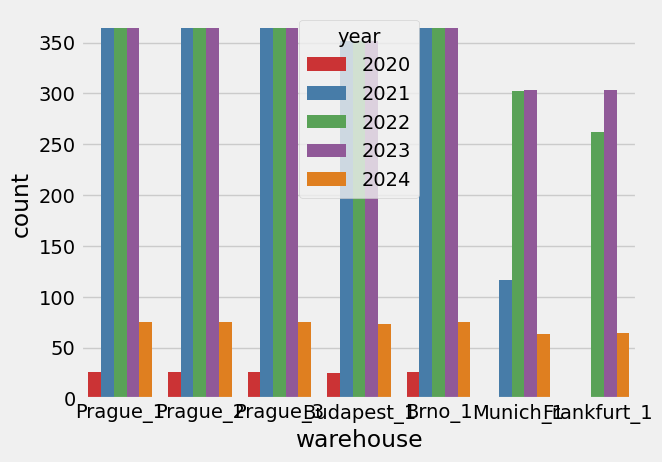

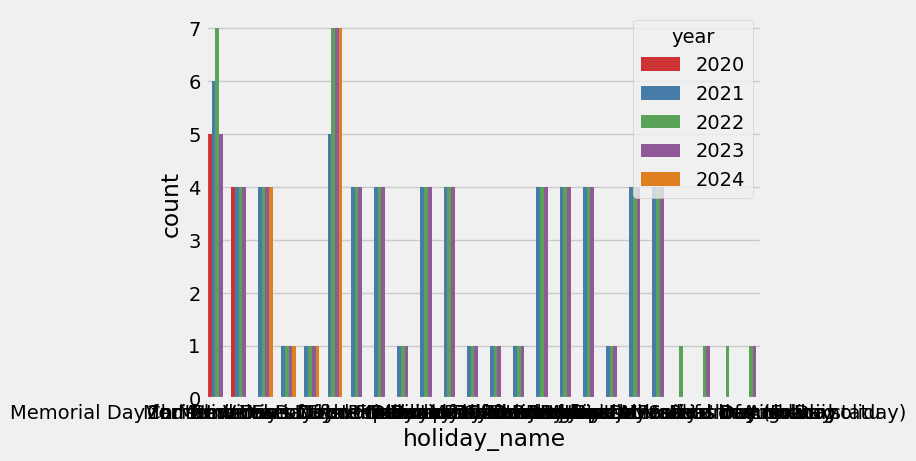

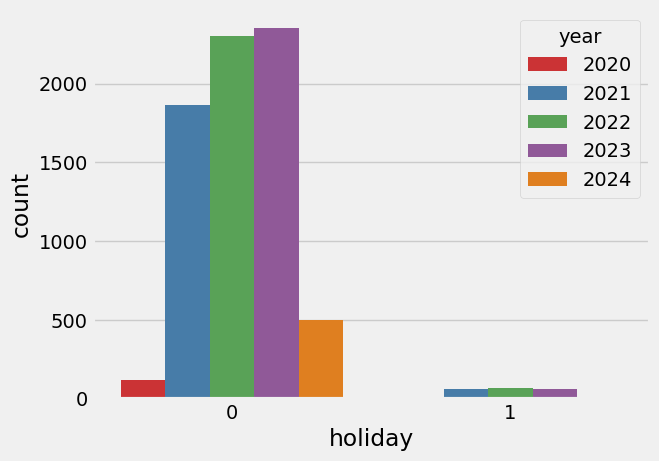

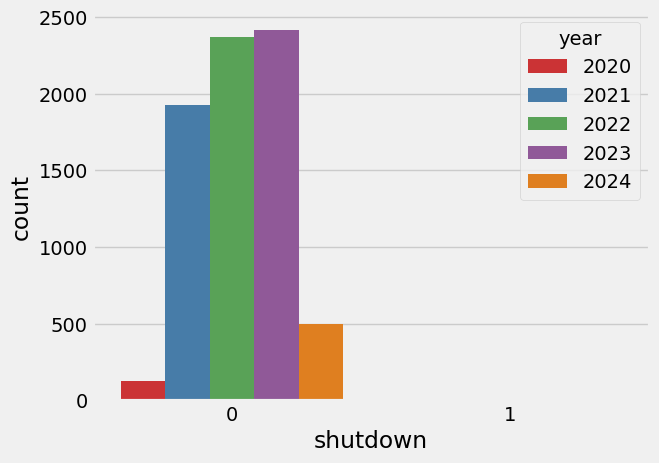

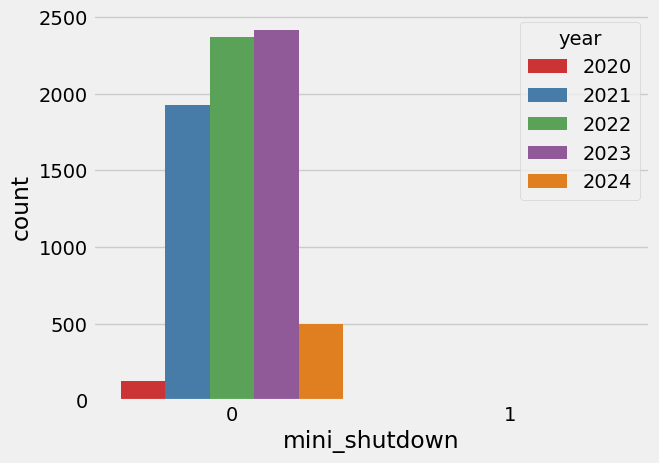

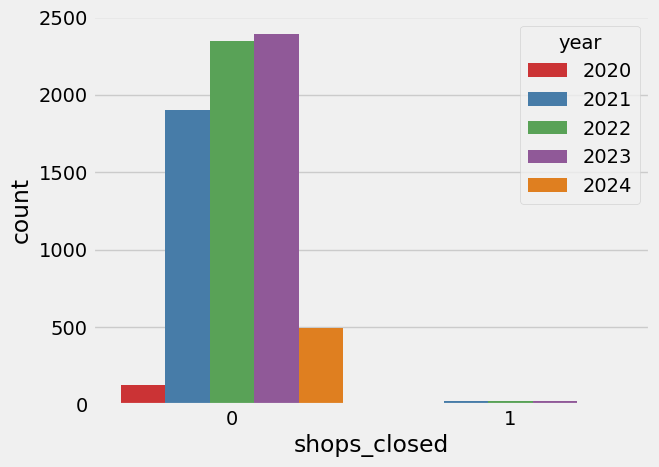

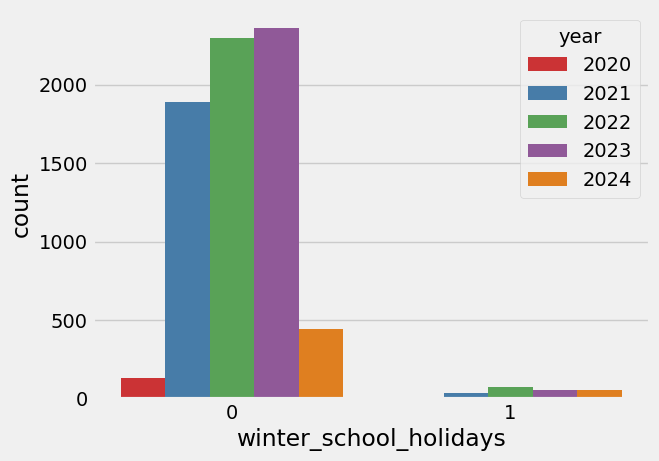

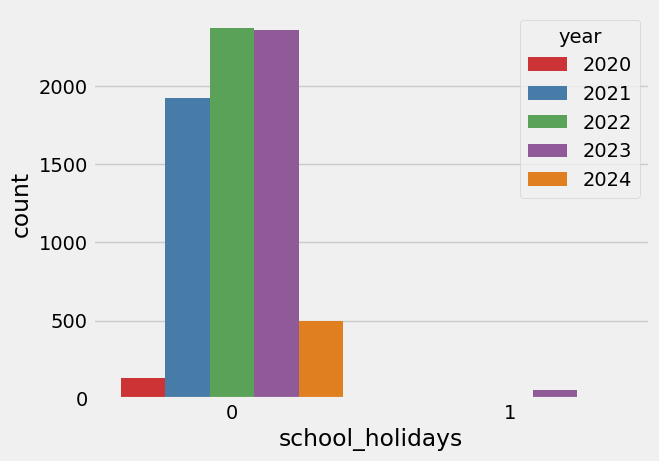

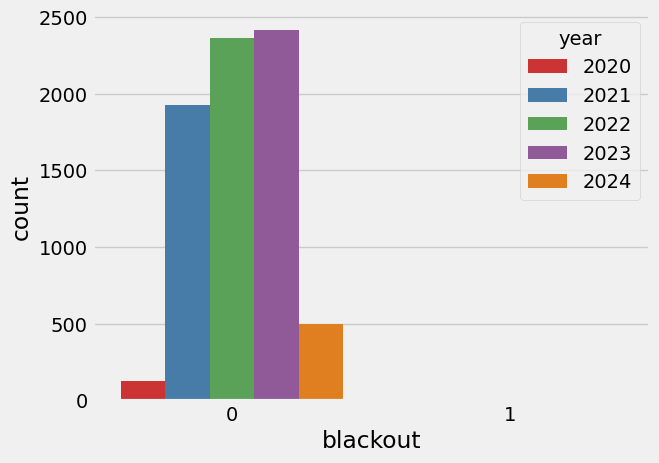

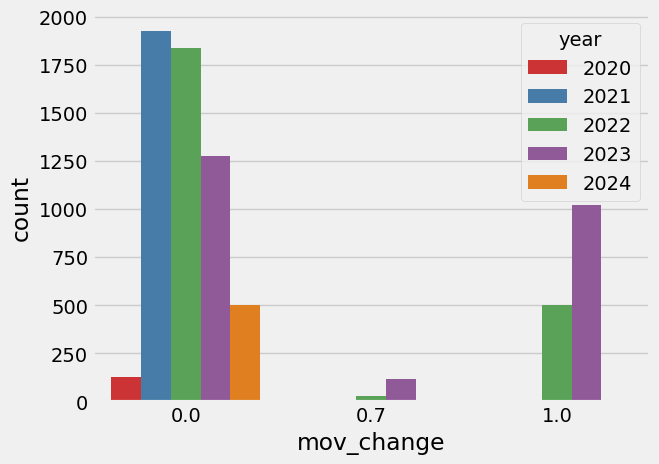

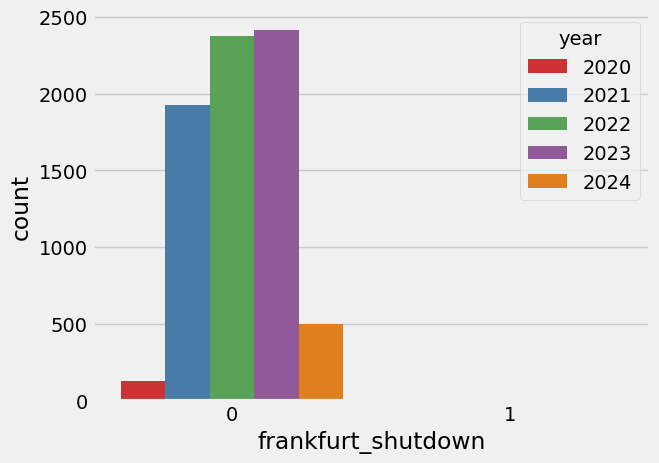

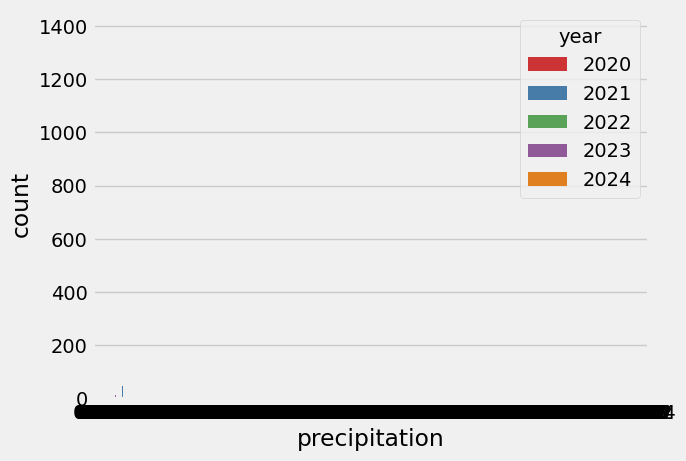

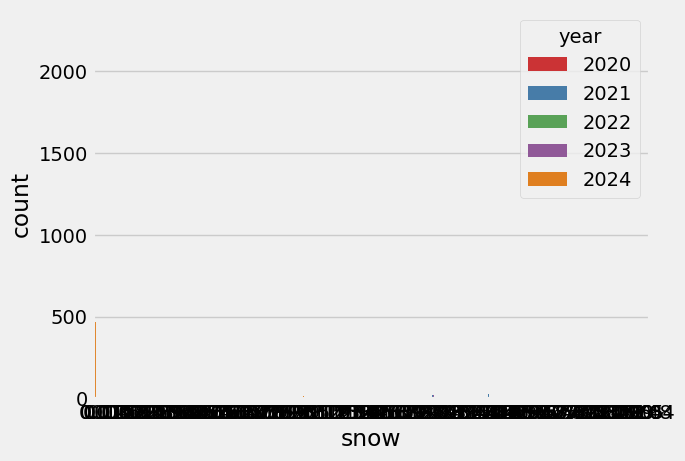

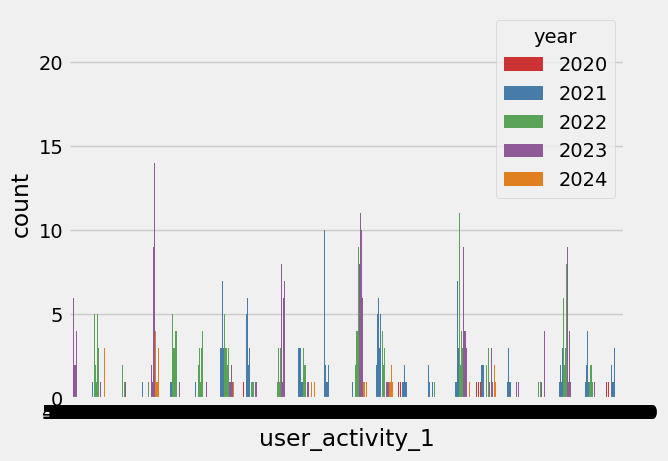

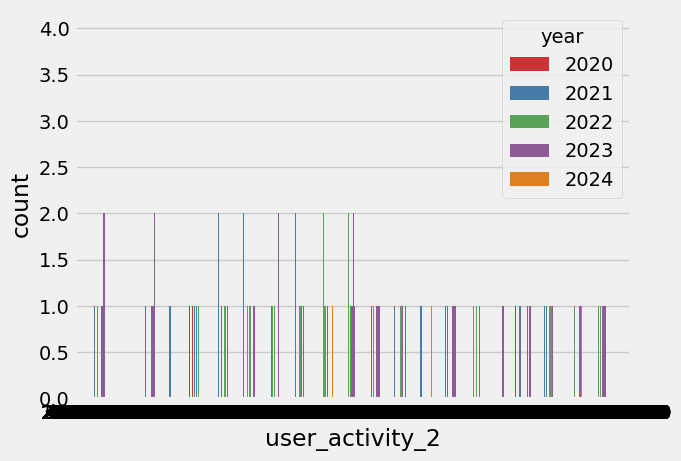

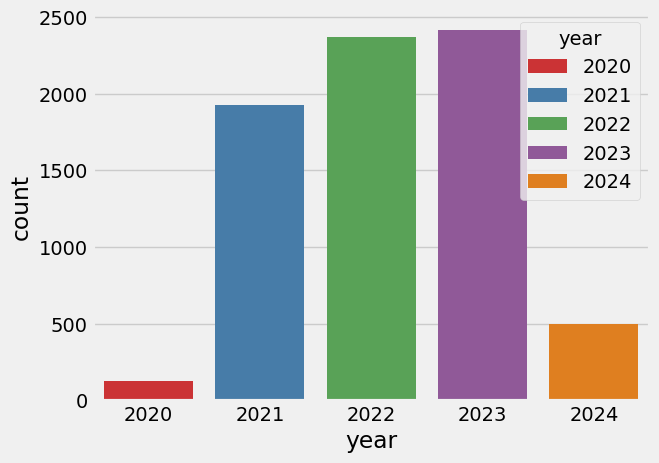

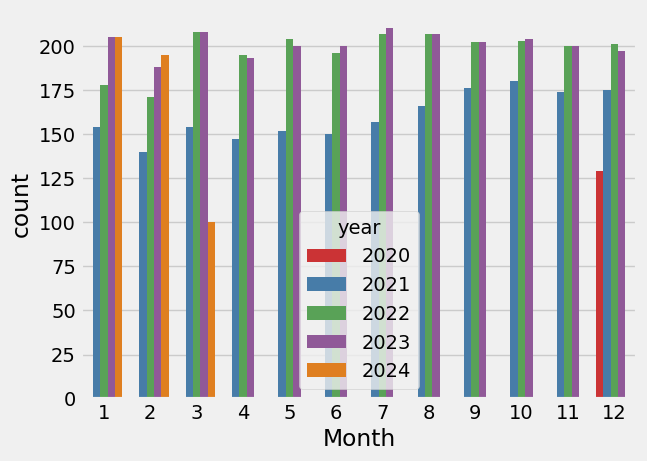

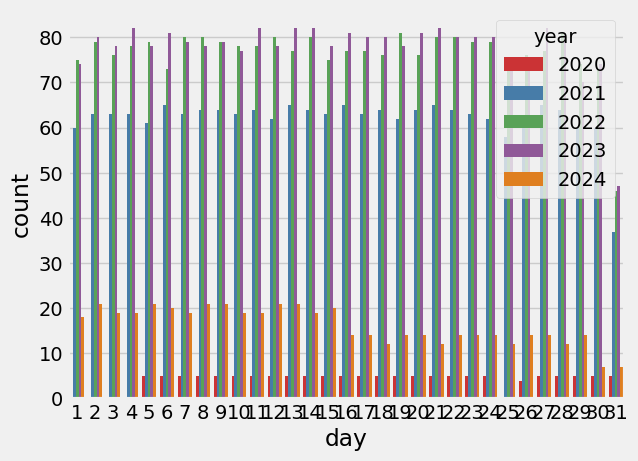

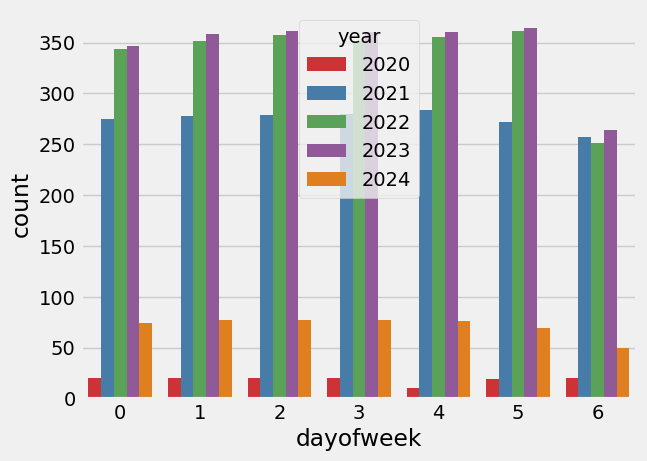

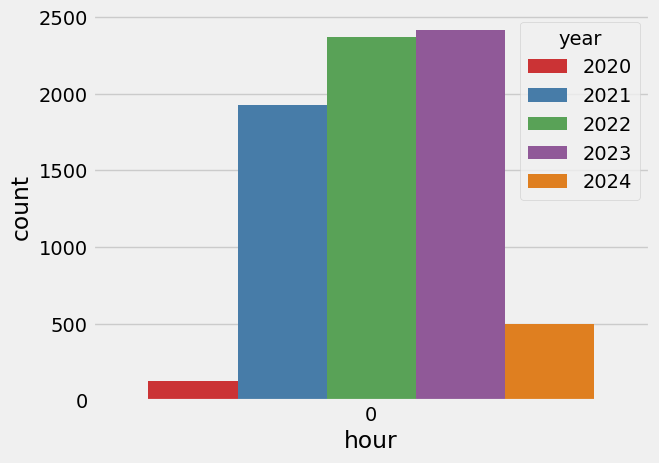

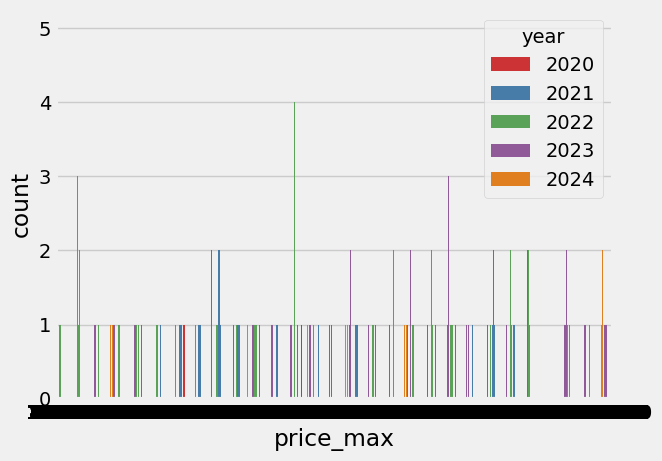

/Users/ahmed/Downloads/computerscience/Kaggle/Rohlik Orders Forecasting Challenge/venv-geoai-ground-level-no2-estimation/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


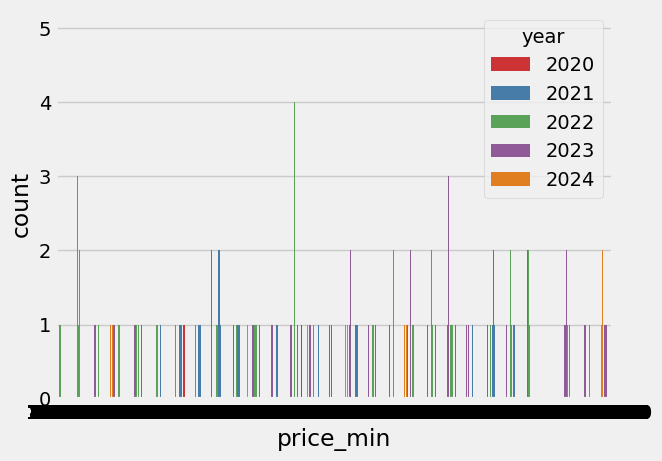

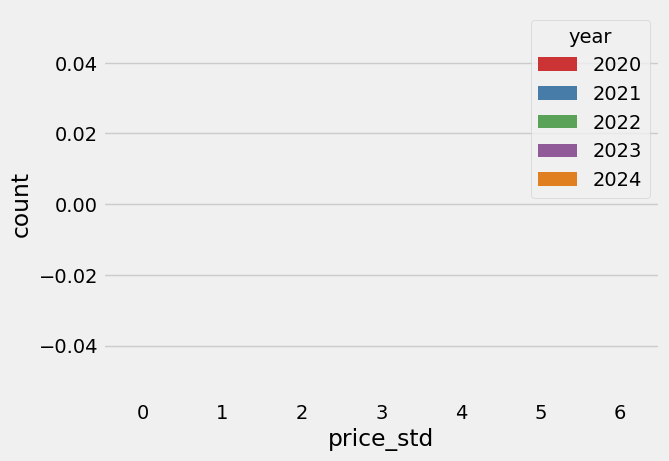

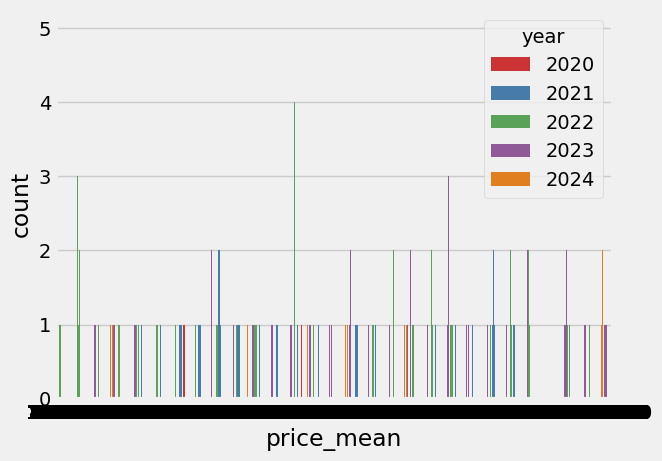

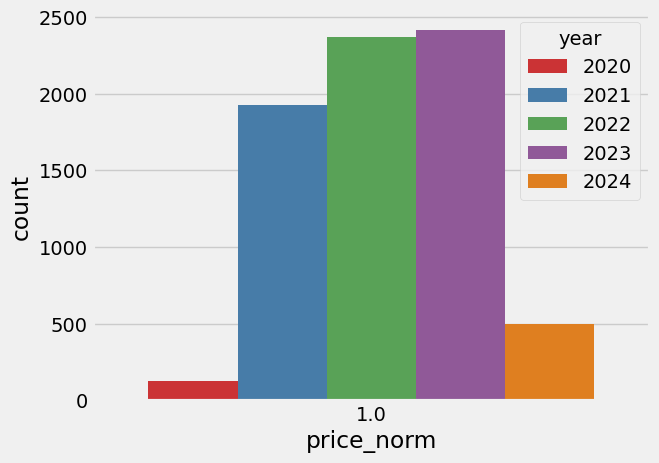

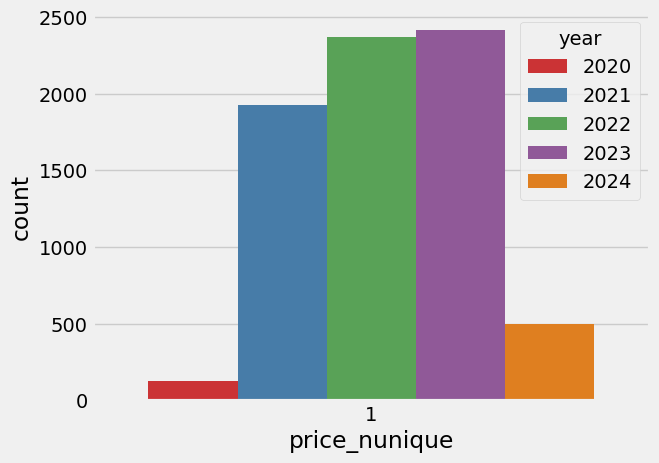

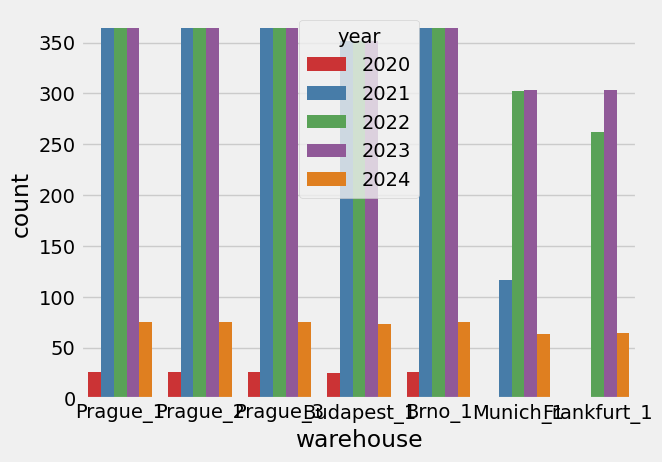

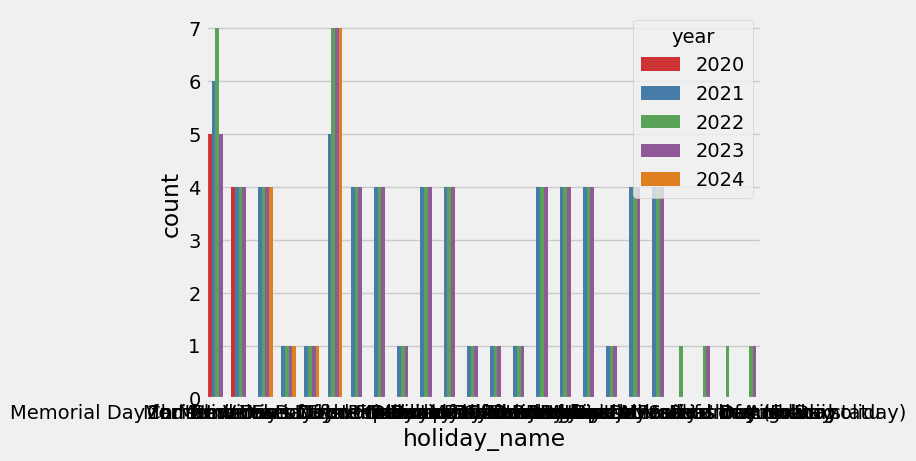

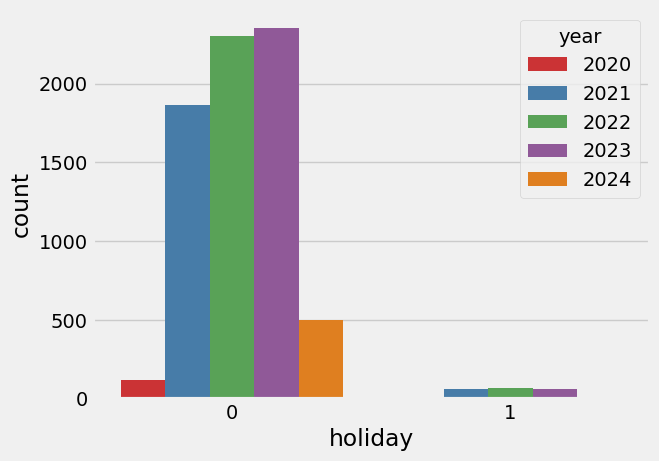

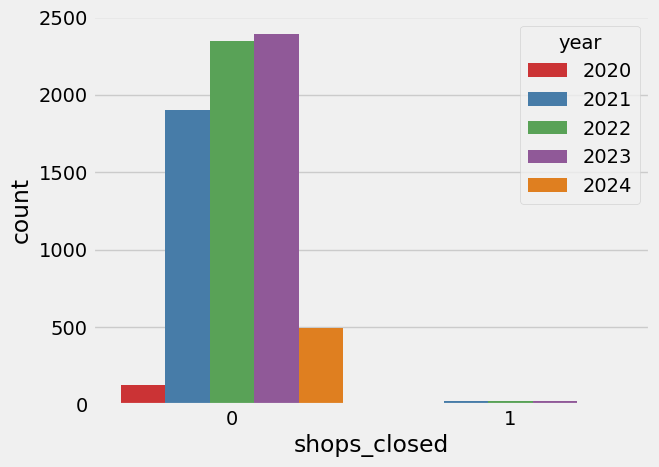

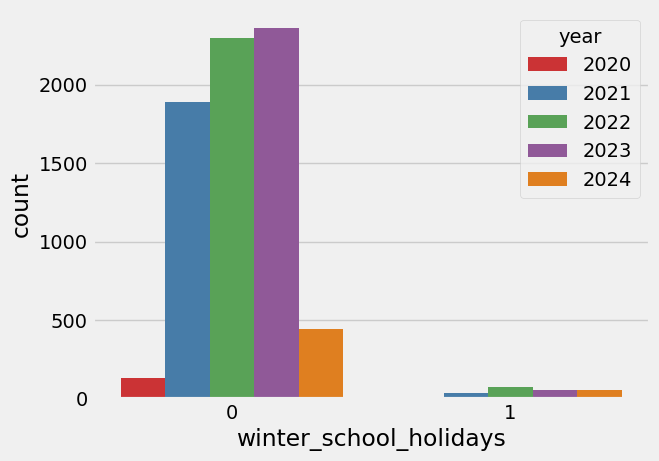

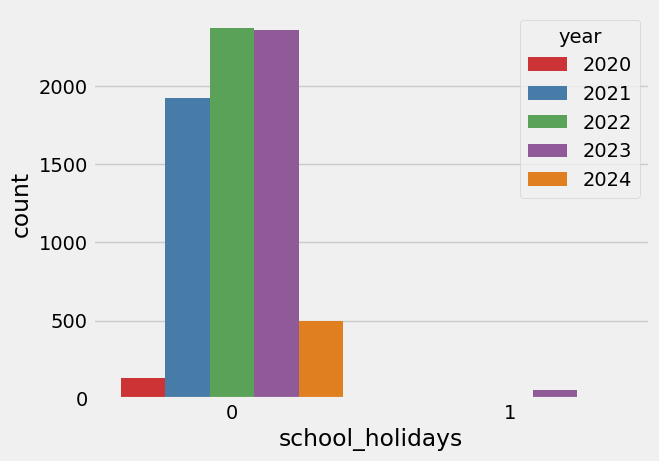

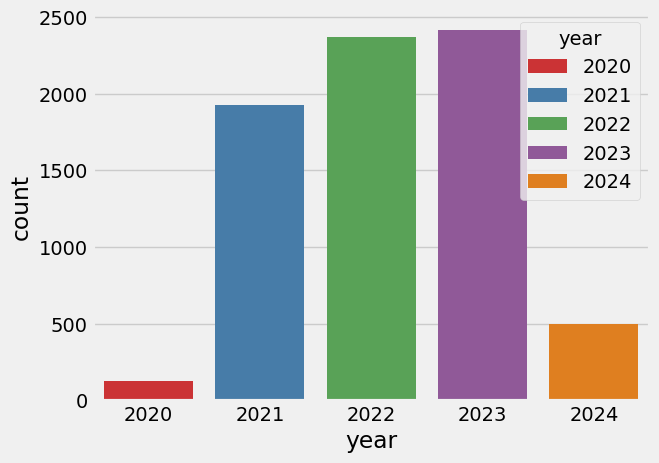

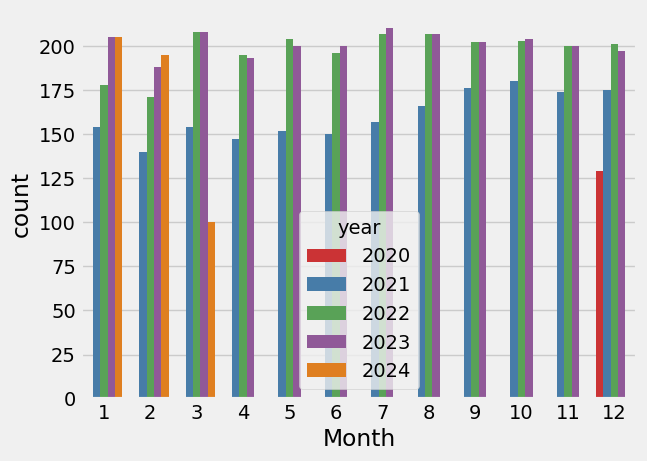

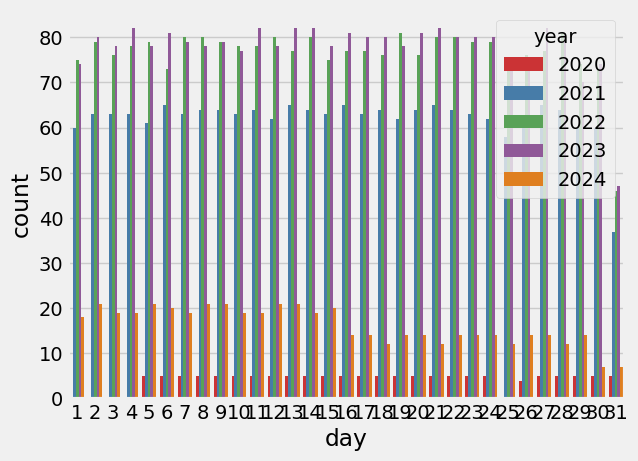

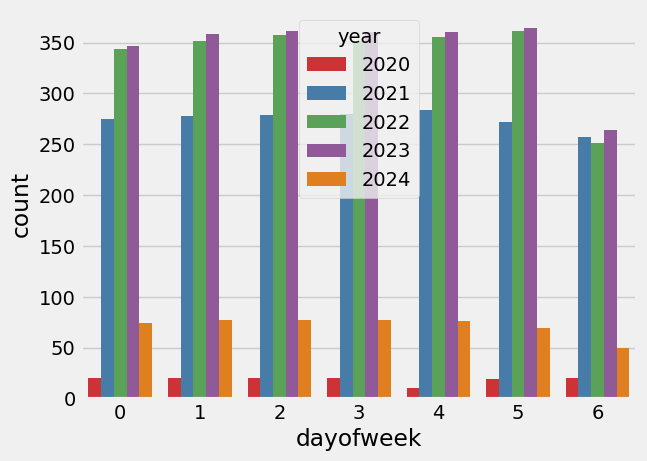

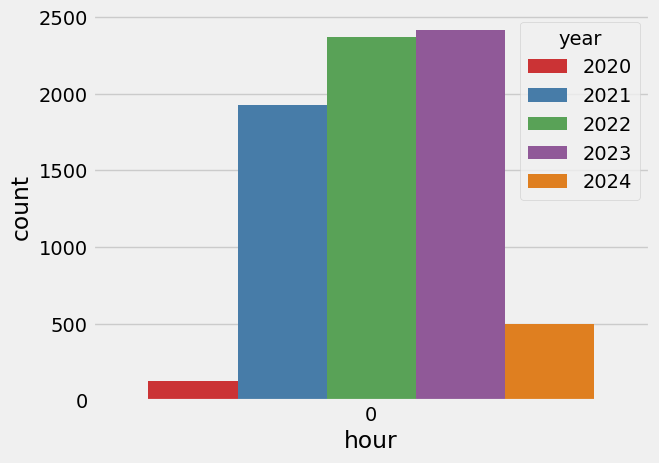

In [37]:
import seaborn as sns
for df in (train,test): 
    for col in df.columns:
        if col not in ['id','orders','day_lag2','day_lag1']: 
            sns.countplot( x=col, data=train, hue="year", palette="Set1");
            plt.show()

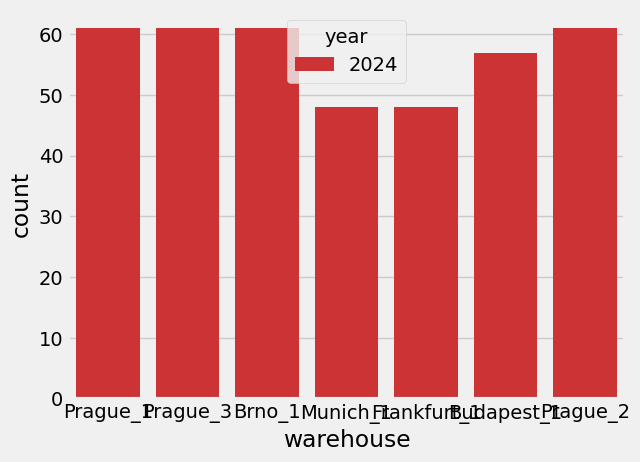

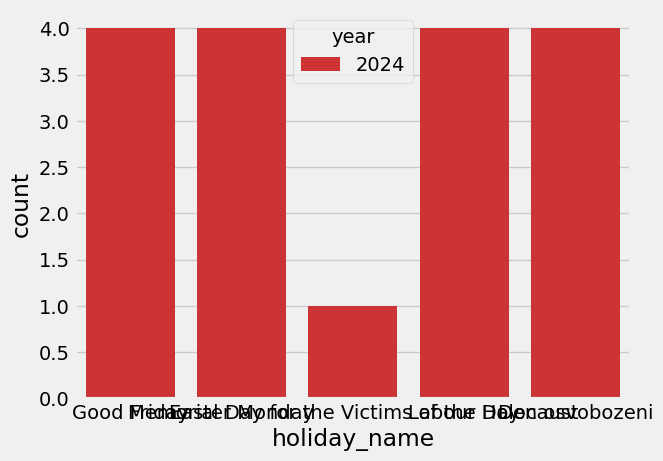

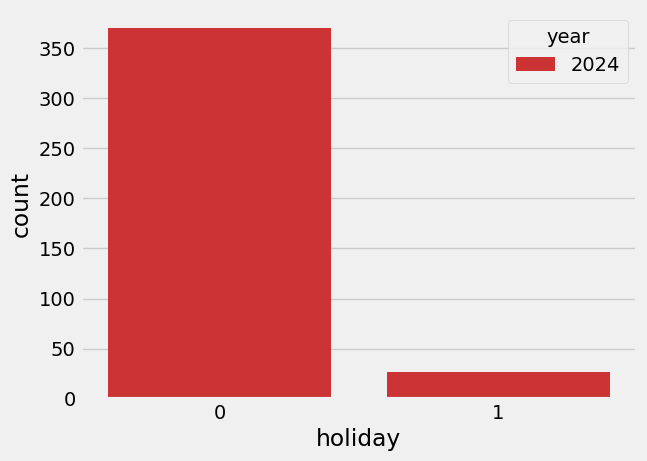

ValueError: Could not interpret value `shutdown` for `x`. An entry with this name does not appear in `data`.

In [38]:
import seaborn as sns
for df in (train,test): 
    for col in df.columns:
        if col not in ['year','id','orders','day_lag2','day_lag1']: 
            sns.countplot( x=col, data=test, hue="year", palette="Set1");
            plt.show()

In [ ]:
#visualize the columns 
fig, ax = plt.subplots(figsize=(13,6))
sns.boxplot(data=train, x='day',y='orders')
ax.set_title('orders by days')

In [ ]:
#visualize the columns 
fig, ax = plt.subplots(figsize=(13,6))
sns.boxplot(data=train, x='month',y='orders')
ax.set_title('orders by hour')

In [ ]:
fig, ax = plt.subplots(figsize=(13,6))
sns.boxplot(data=train, x='year',y='orders')
ax.set_title('orders by years')

In [ ]:
#visualize the columns 
fig, ax = plt.subplots(figsize=(13,6))
sns.boxplot(data=train, x='dayofweek',y='orders')
ax.set_title('orders by hour')

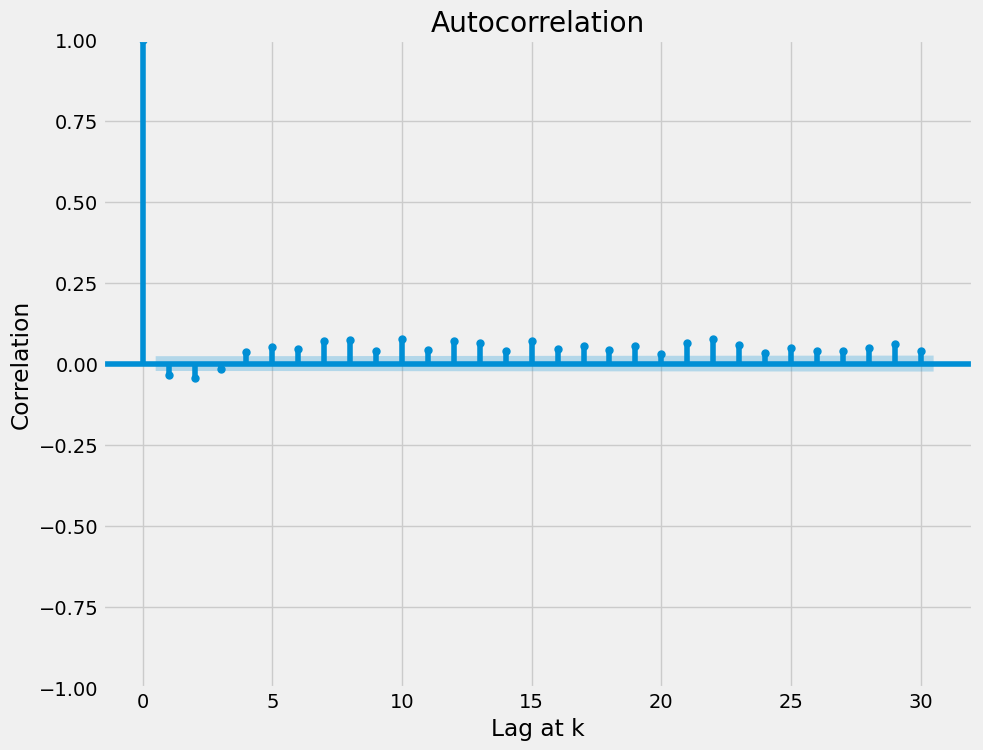

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import rcParams

rcParams["figure.figsize"] = 10, 8
fig = plot_acf(train["orders"].ffill(), lags=30)
plt.title("Autocorrelation")
plt.ylabel("Correlation")
plt.xlabel("Lag at k")
plt.show();

In [ ]:
def rolling(feature):
    for dataset in (train,test):
        dataset['orders_Rolling_3'] = train[feature].rolling(3).mean()
        dataset['orders_Rolling_3_Rolling_5'] = train[feature].rolling(5).mean()

        dataset[f"{feature}_rolling_mean_60"] = train[feature].rolling(60).mean()
        dataset[f"{feature}_rolling_max_60"] = train[feature].rolling(60).max()
        dataset[f"{feature}_rolling_min_60"] = train[feature].rolling(60).min()

        dataset[f"{feature}_rolling_mean_30"] = train[feature].rolling(30).mean()
        dataset[f"{feature}_rolling_max_30"] = train[feature].rolling(30).max()
        dataset[f"{feature}_rolling_min_30"] = train[feature].rolling(30).min()

        dataset[f"{feature}_rolling_mean_10"] = train[feature].rolling(10).mean()
        dataset[f"{feature}_rolling_max_10"] = train[feature].rolling(10).max()
        dataset[f"{feature}_rolling_min_10"] = train[feature].rolling(10).min()

rolling('orders')

In [ ]:
train

In [ ]:
train

# Encoding

In [ ]:
y = train['orders']

features = test.columns.tolist()

train = train.reindex(columns=features)
train['orders'] = y
test = test.reindex(columns=features)


In [ ]:
cat_feats = train.select_dtypes(include='object')
cat_feats

encoder = LabelEncoder()
cat_feats = train.select_dtypes(include='object')
for df in(train,test): 
    for col in df.columns:
        if col in cat_feats:
            df[col] = encoder.fit_transform(df[col])

In [ ]:
for df in (train,test): 
    df.drop('id', axis=1, inplace=True)

In [ ]:
bio = train.dropna(axis=0)

/tmp/ipykernel_34/2825008990.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_rng = pd.date_range(start='1/1/2020', end='1/1/2023', freq='M')


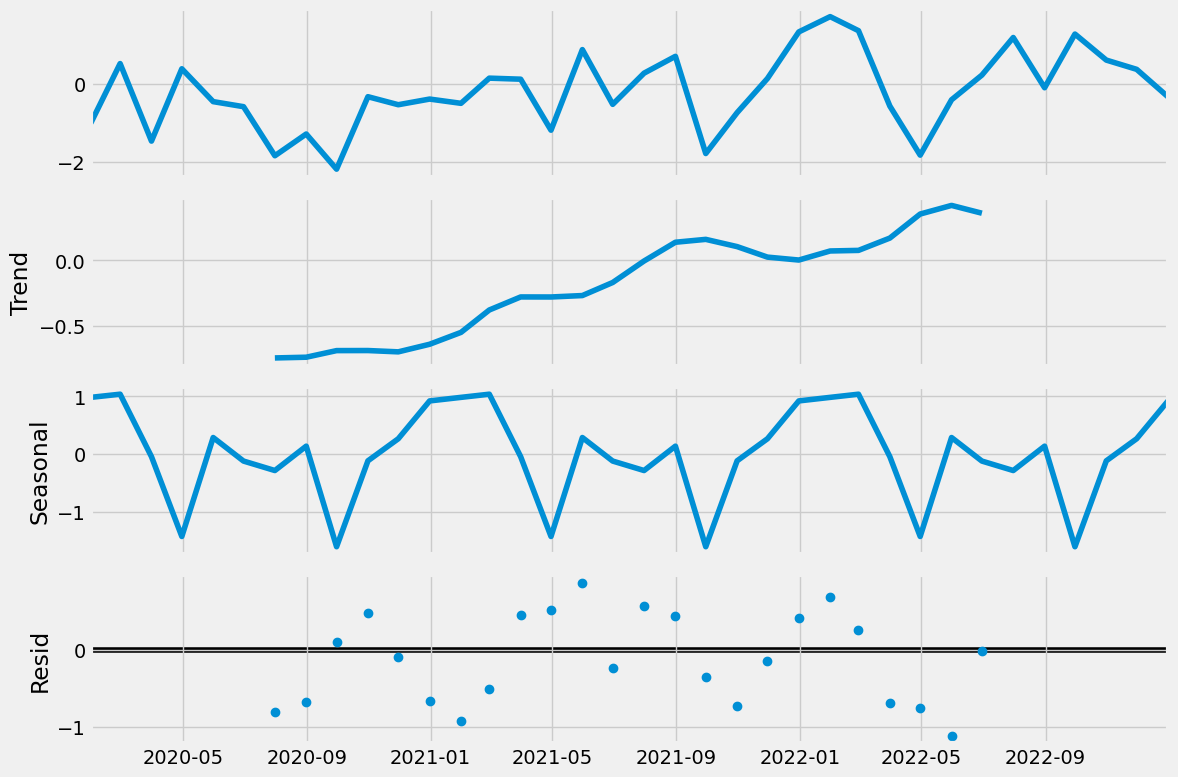

In [ ]:
date_rng = pd.date_range(start='1/1/2020', end='1/1/2023', freq='M')
bio = pd.Series(np.random.randn(len(date_rng)), index=date_rng)
bio = pd.Series(bio, index=date_rng)
CFG = {'img_dim1': 12, 'img_dim2': 8}
plt.rcParams.update({'figure.figsize': (CFG['img_dim1'], CFG['img_dim2'])})
decomposition = seasonal_decompose(bio, period=12)
figure = decomposition.plot()
plt.show()

# Building the CV

In [ ]:
for df in(train,test): 
    df.drop('date', axis=1,inplace=True)

KeyError: "['date'] not found in axis"

In [ ]:
import xgboost as xgb 
model = xgb.XGBRegressor(n_estimator=1000)
from sklearn.model_selection import TimeSeriesSplit
cv = TimeSeriesSplit(n_splits=4)
mapes= []
for v_train,v_test in cv.split(train.drop(columns='orders'),train['orders']):
    train_v, test_v= train.iloc[v_train],train.iloc[v_test]
    model.fit(train_v.drop(columns='orders'),train_v['orders'])
    mape = mean_absolute_percentage_error(model.predict(test_v.drop(columns='orders')),test_v['orders'])
    mapes.append(mape)
    print(mape)

model.fit(X_train,y_train)
y_predict = RFR.predict(test)

sub_df = pd.DataFrame({'id': test_id,'orders':y_predict})
sub_df.to_csv('submissions.csv', index=False)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:03:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


0.3034736513335463


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:03:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


0.08734640694152013


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:03:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


0.05731695734558078


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:03:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


0.11517078246511929


NameError: name 'X_train' is not defined

In [ ]:

RFR = xgb.XGBRegressor(n_estimator=1000)

kf = KFold(n_splits = 5, shuffle=False)
x = train.drop(columns=['orders'],axis=1)
y = train['orders']

mape = []
for train_index, val_index in kf.split(x):
    X_train, X_val = x.iloc[train_index], x.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    RFR.fit(X_train, y_train)
    y_pred = RFR.predict(X_val)

    mape.append(mean_absolute_percentage_error(y_val, y_pred))
    print('Mean Squared Error:', mape)
print(np.mean(mape))
print(np.std(mape))

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:03:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


Mean Squared Error: [0.0935804391338398]


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:03:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


Mean Squared Error: [0.0935804391338398, 0.11239698904897122]


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:03:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


Mean Squared Error: [0.0935804391338398, 0.11239698904897122, 0.060984014456282015]


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:03:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


Mean Squared Error: [0.0935804391338398, 0.11239698904897122, 0.060984014456282015, 0.07639551476973794]


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [09:03:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


Mean Squared Error: [0.0935804391338398, 0.11239698904897122, 0.060984014456282015, 0.07639551476973794, 0.0922015550080908]
0.08711170248338436
0.017346986078484915


In [ ]:
test['prediction'] = RFR.predict(test)
df = train.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = [[y_train]].plot(figsize=(15, 5))
train['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

ValueError: feature_names mismatch: ['warehouse', 'holiday_name', 'holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays', 'year', 'Month', 'day', 'dayofweek', 'hour', 'day_lag1', 'day_lag2', 'orders_Rolling_3', 'orders_Rolling_3_Rolling_5', 'orders_rolling_mean_60', 'orders_rolling_max_60', 'orders_rolling_min_60', 'orders_rolling_mean_30', 'orders_rolling_max_30', 'orders_rolling_min_30', 'orders_rolling_mean_10', 'orders_rolling_max_10', 'orders_rolling_min_10'] ['warehouse', 'holiday_name', 'holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays', 'year', 'Month', 'day', 'dayofweek', 'hour', 'day_lag1', 'day_lag2', 'orders_Rolling_3', 'orders_Rolling_3_Rolling_5', 'orders_rolling_mean_60', 'orders_rolling_max_60', 'orders_rolling_min_60', 'orders_rolling_mean_30', 'orders_rolling_max_30', 'orders_rolling_min_30', 'orders_rolling_mean_10', 'orders_rolling_max_10', 'orders_rolling_min_10', 'prediction']
training data did not have the following fields: prediction

In [ ]:
test['prediction'] = RFR.predict(test)
df = train.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = train[['order']].plot(figsize=(15, 5))
train['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

KeyError: "None of [Index(['order'], dtype='object')] are in the [columns]"

In [ ]:
test

In [ ]:
fi = pd.DataFrame(data=model.feature_importances_,
            index=model.feature_names_in_,
            columns=['importance'])

In [ ]:
fi.sort_values('importance').plot(kind='barh')

In [ ]:
RFR.fit(X_train,y_train)
y_predict = RFR.predict(test)

sub_df = pd.DataFrame({'id': test_id,'orders':y_predict})
sub_df.to_csv('submissions.csv', index=False)

In [ ]:
fga

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

best_params = {
    'n_estimators': 703,
    'learning_rate': 0.06814945127794421,
    'max_depth': 7,
    'reg_alpha': 0.07569481465417208,
    'reg_lambda': 2.1073371397761793,
    'num_leaves': 28,
    'subsample': 0.8680610615626715,
    'colsample_bytree': 0.893976646492343,
    'min_child_weight': 14,
    'min_split_gain': 0.7643791668215504,
    'subsample_freq': 2,
    'min_child_samples': 18
}

model = LGBMClassifier(**best_params, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

mape = mean_absolute_percentage_error(y_val, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)

In [ ]:
x[6000:7400]

In [ ]:
x = x[6000:7400]
y = y[6000:7400]

In [ ]:
from lightgbm import LGBMRegressor
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

best_params = {
    'n_estimators': 703,
    'learning_rate': 0.06814945127794421,
    'max_depth': 7,
    'reg_alpha': 0.07569481465417208,
    'reg_lambda': 2.1073371397761793,
    'num_leaves': 28,
    'subsample': 0.8680610615626715,
    'colsample_bytree': 0.893976646492343,
    'min_child_weight': 14,
    'min_split_gain': 0.7643791668215504,
    'subsample_freq': 2,
    'min_child_samples': 18
}

model = LGBMRegressor(**best_params, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

mape = mean_absolute_percentage_error(y_val, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)

In [ ]:
y_pred = model.predict(test)
sub_df = pd.DataFrame({'id': test_id,'orders':y_pred})
sub_df.to_csv('submissions.csv', index=False)

In [ ]:
y_predict2 = model.fit(X)